# Environement configuration

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

In [ ]:
import shutil
import os

# Remove the existing directory
#shutil.rmtree('pytorch-lr-finder')

# Clone the repository
!git clone https://github.com/davidtvs/pytorch-lr-finder

# Verify the cloned repository
if not os.path.exists('pytorch-lr-finder'):
    print("Failed to clone the repository. Please check the repository URL.")
    exit(1)

# List the files in the cloned repository
print("Repository files:")
for dirpath, dirnames, filenames in os.walk('pytorch-lr-finder'):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

# Copy the file
src_file = os.path.join('pytorch-lr-finder/torch_lr_finder', 'lr_finder.py')
dst_file = 'lr_finder.py'

if not os.path.exists(src_file):
    print(f"Source file '{src_file}' does not exist.")
    exit(1)

try:
    shutil.copy(src_file, dst_file)
    print("File copied successfully.")
except Exception as e:
    print("An error occurred while copying the file:")
    print(e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/QB/data/data

/content/drive/MyDrive/QB/data/data


In [ ]:
#Define custom dataset

class ImageDataset(Dataset):
    def __init__(self, metadata):
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image = self.metadata.iloc[index]['image']
        image = torch.from_numpy(np.array(image)).unsqueeze(0).float()
        label = self.metadata.iloc[index]['plume']
        label = 1 if label == 'yes' else 0
        print(image.shape)

        return image, label

# Load metadata
metadata = pd.read_csv('metadata.csv')

# Load images and labels
images = []
images_path = []
labels = []
for index, row in metadata.iterrows():
    image_path = row['path'] + '.tif'
    label = row['plume']
    image = np.array(Image.open(image_path).convert('L')) / 255.0
    images.append(image)
    images_path.append(image_path)
    labels.append(label)

pd_data_testing = pd.DataFrame({'image': images, 'plume': labels})

train_data, test_data = train_test_split(pd_data_testing, test_size=0.2, random_state=42)

def create_augmented_dataset(train_data) :
  images = []
  images_path = []
  labels = []
  for index, row in train_data.iterrows():
      image = row['image']
      label = row['plume']
      images.append(image)
      images.append(rotate(image, angle=45, mode = 'wrap'))
      images.append(np.fliplr(image))
      images.append(np.flipud(image))
      images.append(random_noise(image,var=0.15**2))
      for j in range(5):
        labels.append(label)
  return images, labels

images, labels = create_augmented_dataset(train_data)

pd_data_training = pd.DataFrame({'image': images, 'plume': labels})

train_data, val_data = train_test_split(pd_data_training, test_size=0.2, random_state=42)

train_dataset = ImageDataset(metadata=train_data)
val_dataset= ImageDataset(metadata=val_data)
test_dataset = ImageDataset(metadata=test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# First CNN : baseline score

In [ ]:
class Net(nn.Module):
    def __init__(self, batch_size=32, hidden_dimension = (64, 128), last_layer_size = 128):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, batch_size, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(batch_size, hidden_dimension[0], 3)
        self.conv3 = nn.Conv2d(hidden_dimension[0], hidden_dimension[1], 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_dimension[1] * 6 * 6, last_layer_size)
        self.fc2 = nn.Linear(last_layer_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
!pip install pytorch-model-summary

from pytorch_model_summary import summary
batch_size = 32
print(summary(Net(), torch.zeros((32, 1, 64, 64)), show_input=True))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1      [32, 1, 64, 64]             320             320
       MaxPool2d-2     [32, 32, 62, 62]               0               0
          Conv2d-3     [32, 32, 31, 31]          18,496          18,496
          Conv2d-4     [32, 64, 14, 14]          73,856          73,856
         Flatten-5      [32, 128, 6, 6]               0               0
          Linear-6           [32, 4608]         589,952         589,952
          Linear-7            [32, 128]             129             129
         Sigmoid-8              [32, 1]               0               0
Total params: 682,753
Trainable params: 682,753
Non-trainable params: 0
------------------------------------------------------------------------


In [ ]:
def train(model, device, train_loader, val_loader, num_epochs, criterion, optimizer) :

  history_auc_train = defaultdict(list)
  for epoch in range(num_epochs):
      running_loss = 0.0
      total_outputs_epoch = []
      total_labels_epoch = []
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)

          loss = criterion(outputs, labels.unsqueeze(1).float())
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          total_outputs_epoch = total_outputs_epoch + list(outputs)
          total_labels_epoch = total_labels_epoch + list(labels)
      
      metrics = compute_metrics(torch.tensor(total_outputs_epoch), torch.tensor(total_labels_epoch))
      print('--------------------------------')
      print(f"Epoch [{epoch+1}/{num_epochs}]")
      print('TRAINING')
      print(f"Loss: {running_loss:.4f}, Accuracy: {metrics['Accuracy']:.2f}, AUC score: {metrics['AUC']:.2f}, F1 score : {metrics['F1 score']:.2f}")
      running_loss = 0.0
      history_auc_train['Train'].append(metrics['AUC'])

      metrics = eval(val_loader, model, device)
      history_auc_train['Validation'].append(metrics['AUC'])
  return history_auc_train


def eval(dataloader, model, device) :
  # Evaluation
  model.eval()
  total_outputs_epoch = []
  total_labels_epoch = []
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in dataloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          total_outputs_epoch = total_outputs_epoch + list(outputs)
          total_labels_epoch = total_labels_epoch + list(labels)
          
  metrics = compute_metrics(torch.tensor(total_outputs_epoch), torch.tensor(total_labels_epoch))
  print('VALIDATION')
  print(f"Accuracy: {metrics['Accuracy']:.2f}, AUC score: {metrics['AUC']:.2f}, F1 score : {metrics['F1 score']:.2f}")
  return metrics


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def compute_metrics(outputs, labels):
    # Convert outputs to binary predictions
    predictions = outputs.detach().cpu().numpy()

    # Convert labels to numpy array
    labels = labels.detach().cpu().numpy()

    # Calculate AUC score
    auc_score = roc_auc_score(labels, predictions)

    predictions = torch.round(outputs).detach().cpu().numpy()
    # Calculate F1 score
    f1 = f1_score(labels, predictions)

    # Calculate accuracy score
    accuracy = accuracy_score(labels, predictions)

    # Return the computed metrics as a dictionary
    metrics = {
        'AUC': auc_score,
        'F1 score': f1,
        'Accuracy': accuracy
    }

    return metrics

In [ ]:
num_epochs = 20


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

#Define loss function and optimizer

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())




In [ ]:
history = train(model, device,  train_loader, val_loader, num_epochs, criterion, optimizer)

In [ ]:
history

defaultdict(list,
            {'Train': [0.6188250478719465,
              0.7340647249875691,
              0.7786655099816976,
              0.8309109952075158,
              0.8632480983464341,
              0.904359785449044,
              0.9355437300974365,
              0.9566539360790495,
              0.9744612422373391,
              0.9807369634903675,
              0.991868645726437,
              0.9963479787988109,
              0.998372882790432,
              0.998931476995017,
              0.9991705722416766,
              0.999390624504089,
              0.9988468415094739,
              0.9995408524909282,
              0.9986606434412789,
              0.9991155591760736],
             'Validation': [0.6646680216802168,
              0.7086043360433605,
              0.720189701897019,
              0.7739159891598917,
              0.8020325203252032,
              0.8140243902439025,
              0.8430216802168021,
              0.8539972899728997,
            

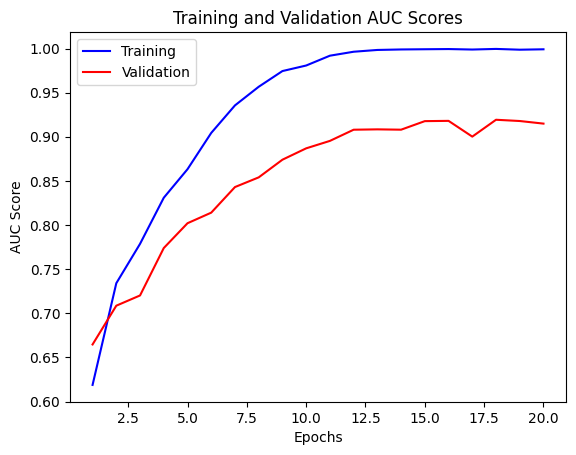

In [ ]:
import matplotlib.pyplot as plt
num_epochs = len(history['Training'])

# Generate x-axis values for epochs
epochs = range(1, 21)

# Plot the curves
plt.plot(epochs, history['Train'], 'b', label='Training')
plt.plot(epochs, history['Validation'], 'r', label='Validation')
plt.title('Training and Validation AUC Scores')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [ ]:
evaluation_results = eval(test_loader, model, device)

VALIDATION
Accuracy: 0.77, AUC score: 0.87, F1 score : 0.79


In [ ]:
file_path = '/content/drive/MyDrive/QB/model/CNN.pkl'
file_path1 = '/content/drive/MyDrive/QB/model/CNN.pt'

# Save the model to the .pkl file
torch.save(model, file_path)

torch.save(model.state_dict(), file_path1)

# Model 2 : 

In [ ]:
!pip install torchvision

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, metadata):
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image = self.metadata.iloc[index]['image']
        image = torch.from_numpy(np.array(image)).unsqueeze(0).float()
        image = np.repeat(image[..., np.newaxis], 3, 0).squeeze()
        label = self.metadata.iloc[index]['plume']
        label = 1 if label == 'yes' else 0

        return image, label

# Load metadata
metadata = pd.read_csv('metadata.csv')

# Load images and labels
images = []
images_path = []
labels = []
for index, row in metadata.iterrows():
    image_path = row['path'] + '.tif'
    label = row['plume']
    image = np.array(Image.open(image_path).convert('L')) / 255.0
    images.append(image)
    images_path.append(image_path)
    labels.append(label)

pd_data_testing = pd.DataFrame({'image': images, 'plume': labels})

train_data, test_data = train_test_split(pd_data_testing, test_size=0.2, random_state=42)

def create_augmented_dataset(train_data) :
  images = []
  images_path = []
  labels = []
  for index, row in train_data.iterrows():
      image = row['image']
      label = row['plume']
      images.append(image)
      images.append(rotate(image, angle=45, mode = 'wrap'))
      images.append(np.fliplr(image))
      images.append(np.flipud(image))
      images.append(random_noise(image,var=0.15**2))
      for j in range(5):
        labels.append(label)
  return images, labels

images, labels = create_augmented_dataset(train_data)

pd_data_training = pd.DataFrame({'image': images, 'plume': labels})

train_data, val_data = train_test_split(pd_data_training, test_size=0.2, random_state=42)

train_dataset = ImageDataset(metadata=train_data)
val_dataset= ImageDataset(metadata=val_data)
test_dataset = ImageDataset(metadata=test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True)


print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)
vgg16 = vgg16.to(device)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=1e-3, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train(model, device, train_loader, val_loader, num_epochs, criterion, optimizer) :

  history_auc_train = defaultdict(list)
  for epoch in range(num_epochs):
      running_loss = 0.0
      total_outputs_epoch = torch.zeros(1, 2).to(device)
      total_labels_epoch = []
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          #labels = labels.unsqueeze(1).float()
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          total_outputs_epoch = torch.cat((total_outputs_epoch, outputs), dim = 0)
          total_labels_epoch = total_labels_epoch + list(labels)
      
      metrics = compute_metrics(total_outputs_epoch[1:, :], torch.tensor(total_labels_epoch))
      print('--------------------------------')
      print(f"Epoch [{epoch+1}/{num_epochs}]")
      print('TRAINING')
      print(f"Loss: {running_loss:.4f}, Accuracy: {metrics['Accuracy']:.2f}, AUC score: {metrics['AUC']:.2f}, F1 score : {metrics['F1 score']:.2f}")
      running_loss = 0.0
      history_auc_train['Train'].append(metrics['AUC'])

      metrics = eval(val_loader, model, device)
      history_auc_train['Validation'].append(metrics['AUC'])
  return history_auc_train


def eval(dataloader, model, device) :
  # Evaluation
  model.eval()
  total_outputs_epoch = torch.zeros(1, 2).to(device)
  total_labels_epoch = []
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in dataloader:
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = model(images)
          total_outputs_epoch = torch.cat((total_outputs_epoch, outputs), dim = 0)
          total_labels_epoch = total_labels_epoch + list(labels)
          
  metrics = compute_metrics(total_outputs_epoch[1:, :], torch.tensor(total_labels_epoch))
  print('VALIDATION')
  print(f"Accuracy: {metrics['Accuracy']:.2f}, AUC score: {metrics['AUC']:.2f},  F1 score : {metrics['F1 score']:.2f}")
  return metrics

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import torch.nn.functional as F

def compute_metrics(outputs, labels):
    outputs = F.softmax(outputs, dim=1)
    # Convert outputs to binary predictions
    predictions = outputs.detach().cpu().numpy()
    predictions = predictions[:, 1]
    # Convert labels to numpy array
    labels = labels.detach().cpu().numpy()

    # Calculate AUC score
    auc_score = roc_auc_score(labels, predictions)

    predictions = torch.round(outputs).detach().cpu().numpy()
    predictions = predictions[:, 1]
    # Calculate F1 score
    f1 = f1_score(labels, predictions)

    # Calculate accuracy score
    accuracy = accuracy_score(labels, predictions)

    # Return the computed metrics as a dictionary
    metrics = {
        'AUC': auc_score,
        'F1 score': f1,
        'Accuracy': accuracy
    }

    return metrics

In [ ]:
num_epochs = 10
history = train(vgg16, device,  train_loader, val_loader, num_epochs, criterion, optimizer_ft)

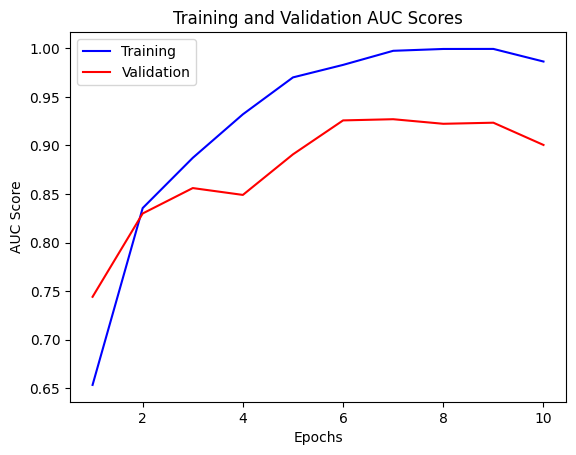

In [ ]:
import matplotlib.pyplot as plt
num_epochs = len(history['Training'])

# Generate x-axis values for epochs
epochs = range(1, 11)

# Plot the curves
plt.plot(epochs, history['Train'], 'b', label='Training')
plt.plot(epochs, history['Validation'], 'r', label='Validation')
plt.title('Training and Validation AUC Scores')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [ ]:
evaluation_results = eval(test_loader, vgg16, device)

VALIDATION
Accuracy: 0.79, AUC score: 0.83,  F1 score : 0.82


In [ ]:
file_path = '/content/drive/MyDrive/QB/model/VGG16.pkl'
file_path1 = '/content/drive/MyDrive/QB/model/VGG16.pt'

# Save the model to the .pkl file
torch.save(vgg16, file_path)

torch.save(vgg16.state_dict(), file_path1)

# Predicting Results

In [ ]:
#Define custom dataset

%cd /content/drive/MyDrive/QB/test data/data

class ImageDataset(Dataset):
    def __init__(self, metadata):
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image = self.metadata.iloc[index]['image']
        image = torch.from_numpy(np.array(image)).unsqueeze(0).float()
        label = self.metadata.iloc[index]['plume']
        label = 1 if label == 'yes' else 0

        return image, label

# Load metadata
metadata = pd.read_csv('metadata.csv')

# Load images and labels
images = []
images_path = []
labels = []
for index, row in metadata.iterrows():
    image_path = row['path'] + '.tif'
    label = row['plume']
    image = np.array(Image.open(image_path).convert('L')) / 255.0
    images.append(image)
    images_path.append(image_path)
    labels.append(label)

pd_data_testing = pd.DataFrame({'image': images, 'plume': labels})

train_data, test_data = train_test_split(pd_data_testing, test_size=0.2, random_state=42)

def create_augmented_dataset(train_data) :
  images = []
  images_path = []
  labels = []
  for index, row in train_data.iterrows():
      image = row['image']
      label = row['plume']
      images.append(image)
      images.append(rotate(image, angle=45, mode = 'wrap'))
      images.append(np.fliplr(image))
      images.append(np.flipud(image))
      images.append(random_noise(image,var=0.15**2))
      for j in range(5):
        labels.append(label)
  return images, labels

images, labels = create_augmented_dataset(train_data)

pd_data_training = pd.DataFrame({'image': images, 'plume': labels})

train_data, val_data = train_test_split(pd_data_training, test_size=0.2, random_state=42)

train_dataset = ImageDataset(metadata=train_data)
val_dataset= ImageDataset(metadata=val_data)
test_dataset = ImageDataset(metadata=test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/QB/model/CNN.pt'))


test_path = '/content/drive/MyDrive/QB/test data/images'
test_images = os.listdir(test_path)
images_paths = []
images = []

for image in test_images:
    images_paths.append(image)
    img_path = os.path.join(test_path, image)
    image = np.array(Image.open(img_path).convert('L')) / 255.0
    images.append(image)


pd_data_testing = pd.DataFrame({'image': images, 'image_path' : images_paths})

class ImageDataset_Test(Dataset):
    def __init__(self, metadata):
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image = self.metadata.iloc[index]['image']
        image = torch.from_numpy(np.array(image)).unsqueeze(0).float()
        image_path = self.metadata.iloc[index]['image_path']
        print(image_path)
        return image, image_path

test_dataset = ImageDataset_Test(metadata=pd_data_testing)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


import pandas as pd

model.eval()
all_paths = []
all_probs = []
for batch in test_loader:
    images, image_paths = batch
    images = images.to(device)
    outputs = model(images).squeeze()
    all_paths += list(image_paths)
    all_probs += list(outputs.cpu().detach().numpy())

results_df = pd.DataFrame({'path': all_paths, 'prediction_score': all_probs})
results_df.to_csv('/content/test.csv', index=False)

  